In [48]:
import numpy as np
from sentinelsat import SentinelAPI

api = SentinelAPI('', '')

## POLYGON used to query the API
<geographic type> = POLYGON((P1Lon P1Lat, P2Lon P2Lat, ..., PnLon PnLat))
where P1Lon and P1Lat are the Longitude and Latitude coordinates of the first point of the polygon in decimal degrees (DDD) format (e.g. 2.17403, 41.40338) and so on.

In [49]:
from sentinelsat import read_geojson, geojson_to_wkt

footprint = geojson_to_wkt(read_geojson('madriz_bbox.geojson'))

products = api.query(footprint,
                     date=('20230101', '20230417'),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=0)

products_df = api.to_geodataframe(products)
products_df.to_file("products.gpkg", layer='footprints', driver="GPKG")

image = products_df.iloc[0]
print(image)

In [50]:
uuid = products_df.iloc[2]['uuid']
print(uuid)
api.download(uuid)

Se descarga un ZIP con los archivos de la imagen. En /S2B_MSIL1C_20230304T105849_N0509_R094_T30TVK_20230304T130129.SAFE/GRANULE/L1C_T30TVK_A031294_20230304T110115/IMG_DATA/ encontramos las imágenes de las diferentes bandas.

In [51]:
import zipfile

zip_ref = zipfile.ZipFile('S2B_MSIL1C_20230304T105849_N0509_R094_T30TVK_20230304T130129.zip', 'r')

# extract only the band 04
zip_ref.extract('S2B_MSIL1C_20230304T105849_N0509_R094_T30TVK_20230304T130129.SAFE/GRANULE/L1C_T30TVK_A031294_20230304T110115/IMG_DATA/T30TVK_20230304T105849_B04.jp2', path='.')

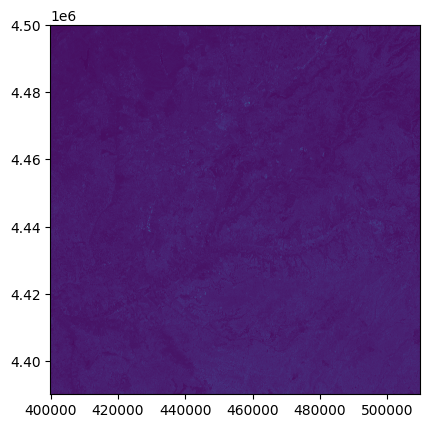

In [3]:
# convert to tiff
import rasterio
from rasterio.plot import show

image_path = 'S2B_MSIL1C_20230304T105849_N0509_R094_T30TVK_20230304T130129.SAFE/GRANULE/L1C_T30TVK_A031294_20230304T110115/IMG_DATA/T30TVK_20230304T105849_B04.jp2'

with rasterio.open(image_path) as src:
    show(src)



In [53]:
# cut the image to the bounding box
from rasterio.mask import mask

with rasterio.open(image_path) as src:
    out_image, out_transform = mask(src, [footprint], crop=True)
    out_meta = src.meta


In [ ]:
import fiona
import pyproj
from shapely.geometry import shape
from shapely.ops import transform

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32630')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

with fiona.open("cutter.geojson", "r") as bbox_geojson:
    shapes = [transform(project, shape(feature["geometry"])) for feature in bbox_geojson]

print(shapes[0].wkt)

In [54]:
NODATA = 0

with rasterio.open(image_path) as src:
    mask_image, mask_transform = rasterio.mask.mask(src,
                                                      shapes,
                                                      crop=True,
                                                      all_touched=True,
                                                      nodata=NODATA)
    out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": mask_image.shape[1],
                     "width": mask_image.shape[2],
                     "transform": mask_transform,
                     "nodata": NODATA
                     })

with rasterio.open(f"{image_path}.cut.tif", "w", **out_meta) as dest:
        dest.write(mask_image)

In [4]:
# open the cut image
import numpy as np
with rasterio.open(f"{image_path}.cut.tif") as src:
    b4 = src.read(1)
    max = np.amax(b4)
    min = np.amin(b4[np.nonzero(b4)])

    print(f"max: {max}, min: {min}")


max: 7001, min: 1401


In [17]:
from rasterio.warp import transform_geom

# Open the raster file
with rasterio.open(f'{image_path}.cut.tif') as src:
    # Convert the point coordinates to the same SRS as the raster file
    point_crs = 'EPSG:4326'  # example coordinate reference system
    point_coords = (40.50653, -3.86588)  # example point coordinates
    point_transformed = transform_geom(point_crs, src.crs, {'type': 'Point', 'coordinates': point_coords})

    # Get the transformation matrix from pixel to map coordinates
    transform = src.transform

    # Invert the transformation matrix to get map to pixel coordinates
    inv_transform = ~transform

    # Apply the inverted transformation to the point coordinates to get the pixel coordinates
    col, row = rasterio.transform.rowcol(inv_transform, point_transformed['coordinates'][0], point_transformed['coordinates'][1])

    # Round the pixel coordinates to the nearest integer

    sample = (426784.1, 4484202.6)
    row = int(round(sample[1]))
    col = int(round(sample[0]))

    # Extract the value from the raster file at the given row and column indices
    value = src.read(1, window=((row, row+1), (col, col+1)))

    print(f'Value at point {point_coords} is {value}')



Value at point (40.50653, -3.86588) is []
